## 第10章: 機械翻訳
本章では，日本語と英語の翻訳コーパスである京都フリー翻訳タスク (KFTT)を用い，ニューラル機械翻訳モデルを構築する．ニューラル機械翻訳モデルの構築には，fairseq，Hugging Face Transformers，OpenNMT-pyなどの既存のツールを活用せよ．

KFTT: http://www.phontron.com/kftt/index-ja.html

### 90. データの準備
機械翻訳のデータセットをダウンロードせよ．訓練データ，開発データ，評価データを整形し，必要に応じてトークン化などの前処理を行うこと．ただし，この段階ではトークンの単位として形態素（日本語）および単語（英語）を採用せよ

In [5]:
# !tar -xf kftt-data-1.0.tar
# !pip install fairseq
# !pip show fairseq

In [1]:
!fairseq-preprocess \
    -s ja -t en \
    --trainpref kftt-data-1.0/data/tok/kyoto-train \
    --validpref kftt-data-1.0/data/tok/kyoto-dev \
    --testpref kftt-data-1.0/data/tok/kyoto-test \
    --destdir data-bin-1 \
    --thresholdtgt 5 \
    --thresholdsrc 5 \
    --workers 16 \
    --task translation

2022-07-08 10:59:07 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-07-08 10:59:07 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin-1', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=Fal

### 91. 機械翻訳モデルの訓練
90で準備したデータを用いて，ニューラル機械翻訳のモデルを学習せよ（ニューラルネットワークのモデルはTransformerやLSTMなど適当に選んでよい）．

note: cuda out of memory エラーよく発生した -> gpu サバー変えた方がいい？ 一応 batch-size の代わりに max-tokens で抑えたらいけた.

In [ ]:
# !CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin \
#     --task translation \
#     --max-tokens 4096 \
#     --arch transformer \
#     --encoder-normalize-before --decoder-normalize-before \
#     --dropout 0.2 \
#     --criterion cross_entropy \
#     --optimizer adam \
#     --lr 1e-3 --lr-scheduler inverse_sqrt \
#     --max-epoch 5 \
#     --save-dir checkpoints \
#     > log_91.log

In [ ]:
# # remove encode/decode-normalize-before + add up epoch -> unk ばっかり
# !CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
#     --task translation \
#     --max-tokens 4096 \
#     --arch transformer \
#     --dropout 0.2 \
#     --criterion cross_entropy \
#     --optimizer adam \
#     --lr 1e-3 --lr-scheduler inverse_sqrt \
#     --max-epoch 10 \
#     --save-dir checkpoints_1 \
#     > log_91_1.log

In [8]:
# same with 1st but less thresholdtgt/src num of dataset
!CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion cross_entropy \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt \
    --max-epoch 5 \
    --save-dir checkpoints_2 \
    > log_91_2.log

epoch 001:   0%|                                       | 0/3599 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 3598/3599 [12:52<00:00,  4.67it/s, loss=5.335, ppl=40.37, wps
epoch 001 | valid on 'valid' subset:   0%|               | 0/13 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  15%|█      | 2/13 [00:00<00:00, 12.62it/s]
epoch 001 | valid on 'valid' subset:  31%|██▏    | 4/13 [00:00<00:00, 14.47it/s]
epoch 001 | valid on 'valid' subset:  46%|███▏   | 6/13 [00:00<00:00, 14.57it/s]
epoch 001 | valid on 'valid' subset:  62%|████▎  | 8/13 [00:00<00:00, 14.40it/s]
epoch 001 | valid on 'valid' subset:  77%|████▌ | 10/13 [00:00<00:00, 14.31it/s]
epoch 001 | valid on 'valid' subset:  92%|█████▌| 12/13 [00:00<00:00, 13.97it/s]
epoch 002: 100%|▉| 3598/3599 

### 92. 機械翻訳モデルの適用
91で学習したニューラル機械翻訳モデルを用い，与えられた（任意の）日本語の文を英語に翻訳するプログラムを実装せよ．

In [22]:
src_text = '天気がいいから、散歩しましょう。'
!echo {src_text} | mecab -Owakati | CUDA_VISIBLE_DEVICES=1 fairseq-interactive data-bin-1\
    --input - \
    --path checkpoints_2/checkpoint_best.pt \
    --beam 5 \
    | grep '^H' \
    | cut -f3

2022-07-09 17:12:23 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-07-09 17:12:24 | INFO | fairseq_cli.interactive | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging

### 93. BLEUスコアの計測
91で学習したニューラル機械翻訳モデルの品質を調べるため，評価データにおけるBLEUスコアを測定せよ

In [ ]:
!CUDA_VISIBLE_DEVICES=1 fairseq-interactive data-bin-1 \
    --path checkpoints_2/checkpoint_best.pt \
    -s ja -t en \
    < kftt-data-1.0/data/tok/kyoto-test.ja | grep '^H' | cut -f3 > test_93_2_2.out

In [23]:
!head test_93_2_2.out

<unk>
Dogen was a Zen monk in the early Kamakura period .
He was the founder of the Soto sect .
In his later years , he was also called <unk> .
He was called Koso in <unk> .
His posthumous Buddhist name was <unk> Kokushi and <unk> Daishi .
It is generally called Dogen Zenji .
It is said that the practice of cleaning and cleaning was spread in Japan .
There is a theory that he first brought <unk> ( Phyllostachys <unk> ) back .
Although there are many questions about Dogen 's birth , there are various opinions on the possibility that he was born into the direct descendants of Michichika TSUCHIMIKADO , who was Naidaijin ( minister of the center ) ( MINAMOTO no Michichika or Michichika ) .


In [21]:
!fairseq-score --sys test_93_2_2.out --ref kftt-data-1.0/data/tok/kyoto-test.en

2022-07-09 17:06:28 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
Namespace(ignore_case=False, order=4, ref='kftt-data-1.0/data/tok/kyoto-test.en', sacrebleu=False, sentence_bleu=False, sys='test_93_2_2.out')
BLEU4 = 20.19, 53.4/26.3/15.1/9.4 (BP=0.957, ratio=0.958, syslen=25599, reflen=26734)


### 94. ビーム探索
91で学習したニューラル機械翻訳モデルで翻訳文をデコードする際に，ビーム探索を導入せよ．ビーム幅を1から100くらいまで適当に変化させながら，開発セット上のBLEUスコアの変化をプロットせよ．

In [ ]:
# 各 beam 幅の場合の翻訳文を生成
beams = [1] + list(range(5, 101, 5)) # 1, 5, 10, 15, ..., 100
for N in beams:
    !CUDA_VISIBLE_DEVICES=1 fairseq-interactive data-bin-1 \
    --path checkpoints_2/checkpoint_best.pt \
    -s ja -t en \
    --beam {N} \
    < kftt-data-1.0/data/tok/kyoto-dev.ja | grep '^H' | cut -f3 > out_94/dev_94_{N}.out

In [ ]:
# 各ビーム幅の場合 BLEU score を求める
for N in beams:
    !fairseq-score --sys out_94/dev_94_{N}.out --ref kftt-data-1.0/data/tok/kyoto-dev.en > out_94/bleu_94_{N}.score

In [5]:
# プロット
import matplotlib.pyplot as plt
import re

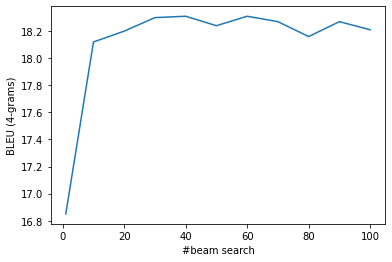

In [28]:
score_list = []
for N in beams:
    with open("out_94/bleu_94_"+str(N)+".score", "r") as f:
        texts = f.read()
        score = re.search(r"(?<=BLEU4\s=\s)\d+\.\d+(?=,)", texts)
        score_list.append(float(score.group(0)))

plt.plot(beams, score_list)
plt.xlabel("#beam search")
plt.ylabel("BLEU (4-grams)")
plt.show()

### 95. サブワード化
トークンの単位を単語や形態素からサブワードに変更し，91-94の実験を再度実施せよ．

In [ ]:
# !pip install subword-nmt

In [18]:
# 文の数を確認 -> 一応これを参考に bpe の merge operation 数を決める
!wc -l kftt-data-1.0/data/orig/kyoto-train.ja

440288 kftt-data-1.0/data/orig/kyoto-train.ja


In [19]:
# サブワードの学習
# !mkdir out_95
!subword-nmt learn-bpe -s 4000 < kftt-data-1.0/data/orig/kyoto-train.ja > out_95/codes_95.ja
!subword-nmt learn-bpe -s 4000 < kftt-data-1.0/data/orig/kyoto-train.en > out_95/codes_95.en

100%|######################################| 4000/4000 [00:18<00:00, 214.98it/s]


In [20]:
# 学習したサブワードによって train/dev/test データ（文章）のサブワード化されたファイルを作成
!subword-nmt apply-bpe -c out_95/codes_95.ja < kftt-data-1.0/data/orig/kyoto-train.ja > kftt-data-1.0/data/subw/kyoto-train.ja
!subword-nmt apply-bpe -c out_95/codes_95.ja < kftt-data-1.0/data/orig/kyoto-dev.ja > kftt-data-1.0/data/subw/kyoto-dev.ja
!subword-nmt apply-bpe -c out_95/codes_95.ja < kftt-data-1.0/data/orig/kyoto-test.ja > kftt-data-1.0/data/subw/kyoto-test.ja

!subword-nmt apply-bpe -c out_95/codes_95.en < kftt-data-1.0/data/orig/kyoto-train.en > kftt-data-1.0/data/subw/kyoto-train.en
!subword-nmt apply-bpe -c out_95/codes_95.en < kftt-data-1.0/data/orig/kyoto-dev.en > kftt-data-1.0/data/subw/kyoto-dev.en
!subword-nmt apply-bpe -c out_95/codes_95.en < kftt-data-1.0/data/orig/kyoto-test.en > kftt-data-1.0/data/subw/kyoto-test.en

In [3]:
!head -n 5 kftt-data-1.0/data/subw/kyoto-train.ja
!head -n 5 kftt-data-1.0/data/subw/kyoto-train.en

雪@@ 舟@@ （@@ せ@@ っ@@ しゅう@@ 、@@ 14@@ 20@@ 年（@@ 応永@@ 2@@ 7年）@@ -@@ 15@@ 0@@ 6年（@@ 永正@@ 3年）@@ ）は@@ 号@@ で、@@ 15@@ 世紀後半@@ 室町@@ 時代に@@ 活躍@@ した@@ 水@@ 墨@@ 画@@ 家・@@ 禅@@ 僧@@ で、@@ 画@@ 聖@@ とも称@@ えられ@@ る。
日本の@@ 水@@ 墨@@ 画@@ を一@@ 変@@ させた。
諱@@ は「@@ 等@@ 楊@@ （@@ とう@@ よう@@ ）@@ 」、@@ も@@ しく@@ は「@@ 拙@@ 宗@@ （@@ せ@@ っ@@ しゅう@@ ）@@ 」と@@ 号@@ した。
備@@ 中国@@ に@@ 生まれ@@ 、@@ 京都・@@ 相@@ 国@@ 寺@@ に入って@@ から@@ 周@@ 防@@ 国に@@ 移@@ る。
その後@@ 遣@@ 明@@ 使@@ に@@ 随@@ 行@@ して@@ 中国@@ （@@ 明@@ ）に@@ 渡@@ って@@ 中国の@@ 水@@ 墨@@ 画@@ を学@@ んだ。
K@@ n@@ own as S@@ es@@ shu (@@ 14@@ 20 - 15@@ 0@@ 6@@ ), he was an in@@ k pain@@ ter and Zen monk active in the Muromachi period in the latter half of the 15@@ th century, and was called a master pain@@ ter@@ .
He re@@ vol@@ ut@@ ion@@ ized the Japanese in@@ k paint@@ ing.
He was given the posthumous name "@@ Toyo@@ " or "S@@ es@@ shu (@@ 拙@@ 宗@@ )@@ ."
B@@ or@@ n in B@@ ic@@ chu Province, he moved to Su@@ o Province after ent@@ ering S@@ Shok@@ oku@@ -ji Temple in Kyoto.
L@@ ater he accompan@@ ied a mission to M

In [2]:
import os

os.environ["MKL_THREADING_LAYER"] = "GNU" # これ設定しないと以下の preprocess が実行できない...

In [28]:
# 91. の再実験 (前処理+学習)
!fairseq-preprocess \
    -s ja -t en \
    --trainpref kftt-data-1.0/data/subw/kyoto-train \
    --validpref kftt-data-1.0/data/subw/kyoto-dev \
    --testpref kftt-data-1.0/data/subw/kyoto-test \
    --destdir out_95/data-bin \
    --thresholdtgt 5 \
    --thresholdsrc 5 \
    --workers 16 \
    --task translation

2022-07-09 22:17:23 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-07-09 22:17:23 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='out_95/data-bin', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profil

In [29]:
!CUDA_VISIBLE_DEVICES=1 fairseq-train out_95/data-bin \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion cross_entropy \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt \
    --max-epoch 5 \
    --save-dir out_95/checkpoints \
    > out_95/log_95.log

epoch 001:   0%|                                       | 0/4567 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 4566/4567 [10:14<00:00,  7.35it/s, loss=4.628, ppl=24.73, wps
epoch 001 | valid on 'valid' subset:   0%|               | 0/18 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  11%|▊      | 2/18 [00:00<00:00, 19.44it/s]
epoch 001 | valid on 'valid' subset:  28%|█▉     | 5/18 [00:00<00:00, 24.47it/s]
epoch 001 | valid on 'valid' subset:  44%|███    | 8/18 [00:00<00:00, 25.40it/s]
epoch 001 | valid on 'valid' subset:  61%|███▋  | 11/18 [00:00<00:00, 25.73it/s]
epoch 001 | valid on 'valid' subset:  78%|████▋ | 14/18 [00:00<00:00, 25.54it/s]
epoch 001 | valid on 'valid' subset:  94%|█████▋| 17/18 [00:00<00:00, 26.89it/s]
epoch 002: 100%|▉| 4566/4567 

In [11]:
# 92. の再実験
src_text = '天気がいいから、散歩しましょう。'
!echo {src_text} | subword-nmt apply-bpe -c out_95/codes_95.ja | CUDA_VISIBLE_DEVICES=1 fairseq-interactive out_95/data-bin \
    --input - \
    --path out_95/checkpoints/checkpoint_best.pt \
    --beam 5 \
    | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g'

2022-07-25 23:02:45 | INFO | fairseq_cli.interactive | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_na

In [ ]:
# 93. の再実験: 評価データの BLEU score
!CUDA_VISIBLE_DEVICES=1 fairseq-interactive out_95/data-bin \
    --path out_95/checkpoints/checkpoint_best.pt \
    -s ja -t en \
    < kftt-data-1.0/data/subw/kyoto-test.ja | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g'> out_95/test_95.out

In [38]:
!head out_95/test_95.out

If. Bux Buxing
Dogen was a Zen priest in the early Kamakura period.
He was the founder of the Soto sect.
It was also called Maregen in his later years.
In the same sect, it is called Koso (high ancestral ancestral temple).
His shigo (posthumous name) was Bussho Densho Kokushi and Jyoyo Daishi (priest).
It is generally called Dogen Zenji.
It is said that the custom of eating and cleaning and cleaning was spread in Japan and when eating and eating ceremony.
There is a theory that he first brought back Mosochiku (Mencius) at first.
Although the birth of Dogen is unknown, there are various theories regarding the birth of Naidaijin (minister of the center) Michichika TSUCHIMIKADO (MINAMOTO no Michichika or Michichika KOGA).


In [39]:
!fairseq-score --sys out_95/test_95.out --ref kftt-data-1.0/data/orig/kyoto-test.en

2022-07-09 23:23:49 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
Namespace(ignore_case=False, order=4, ref='kftt-data-1.0/data/orig/kyoto-test.en', sacrebleu=False, sentence_bleu=False, sys='out_95/test_95.out')
BLEU4 = 13.89, 39.9/18.6/9.6/5.2 (BP=1.000, ratio=1.004, syslen=22145, reflen=22063)


In [ ]:
# 94.の再実験: (開発データで) beam search の数の変化の影響を調べる
# 各 beam の場合の翻訳結果を求める

# !mkdir out_95/beamsearch
beams = [1] + list(range(5, 101, 5)) # 1, 5, 10, 15, ..., 100
for N in beams:
    !CUDA_VISIBLE_DEVICES=1 fairseq-interactive out_95/data-bin \
    --path out_95/checkpoints/checkpoint_best.pt \
    -s ja -t en \
    --beam {N} \
    < kftt-data-1.0/data/subw/kyoto-dev.ja | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g' > out_95/beamsearch/dev_95_{N}.out

In [ ]:
# score を求める
!mkdir out_95/bleu
for N in beams:
    !fairseq-score --sys out_95/beamsearch/dev_95_{N}.out --ref kftt-data-1.0/data/orig/kyoto-dev.en > out_95/bleu/bleu_95_{N}.score

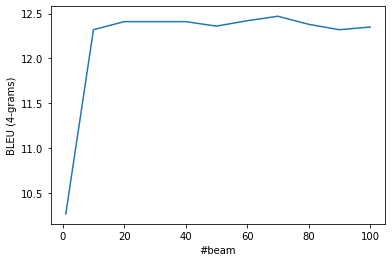

In [27]:
# plot
score_list = []
for N in beams:
    with open("out_95/bleu/bleu_95_"+str(N)+".score", "r") as f:
        texts = f.read()
        score = re.search(r"(?<=BLEU4\s=\s)\d+\.\d+(?=,)", texts)
        score_list.append(float(score.group(0)))

plt.plot(beams, score_list)
plt.xlabel("#beam")
plt.ylabel("BLEU (4-grams)")
plt.show()

### 96. 学習過程の可視化
[Tensorboard](https://www.tensorflow.org/tensorboard)などのツールを用い，ニューラル機械翻訳モデルが学習されていく過程を可視化せよ．可視化する項目としては，学習データにおける損失関数の値とBLEUスコア，開発データにおける損失関数の値とBLEUスコアなどを採用せよ．

In [6]:
# !pip install tensorboard tensorboardX

In [3]:
!CUDA_VISIBLE_DEVICES=1 fairseq-train out_95/data-bin \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion cross_entropy \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt \
    --max-epoch 5 \
    --save-dir out_96/checkpoints_1 \
    --tensorboard-logdir out_96/tb_log_96 \
    > out_96/log_96_2.log

epoch 001:   0%|                                       | 0/4567 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 4566/4567 [10:16<00:00,  7.32it/s, loss=4.628, ppl=24.73, wps
epoch 001 | valid on 'valid' subset:   0%|               | 0/18 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  11%|▊      | 2/18 [00:00<00:00, 18.80it/s]
epoch 001 | valid on 'valid' subset:  28%|█▉     | 5/18 [00:00<00:00, 24.19it/s]
epoch 001 | valid on 'valid' subset:  44%|███    | 8/18 [00:00<00:00, 25.22it/s]
epoch 001 | valid on 'valid' subset:  61%|███▋  | 11/18 [00:00<00:00, 25.63it/s]
epoch 001 | valid on 'valid' subset:  78%|████▋ | 14/18 [00:00<00:00, 25.51it/s]
epoch 001 | valid on 'valid' subset:  94%|█████▋| 17/18 [00:00<00:00, 26.84it/s]
epoch 002: 100%|▉| 4566/4567 

Tensorboard で可視化結果：

(run command `tensorboard --logdir [file_name]`)

In [3]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img = mpimg.imread("out_96/tensorboard_results.png")
# fig = plt.figure(dpi=200)
# imgplot = plt.imshow(img)

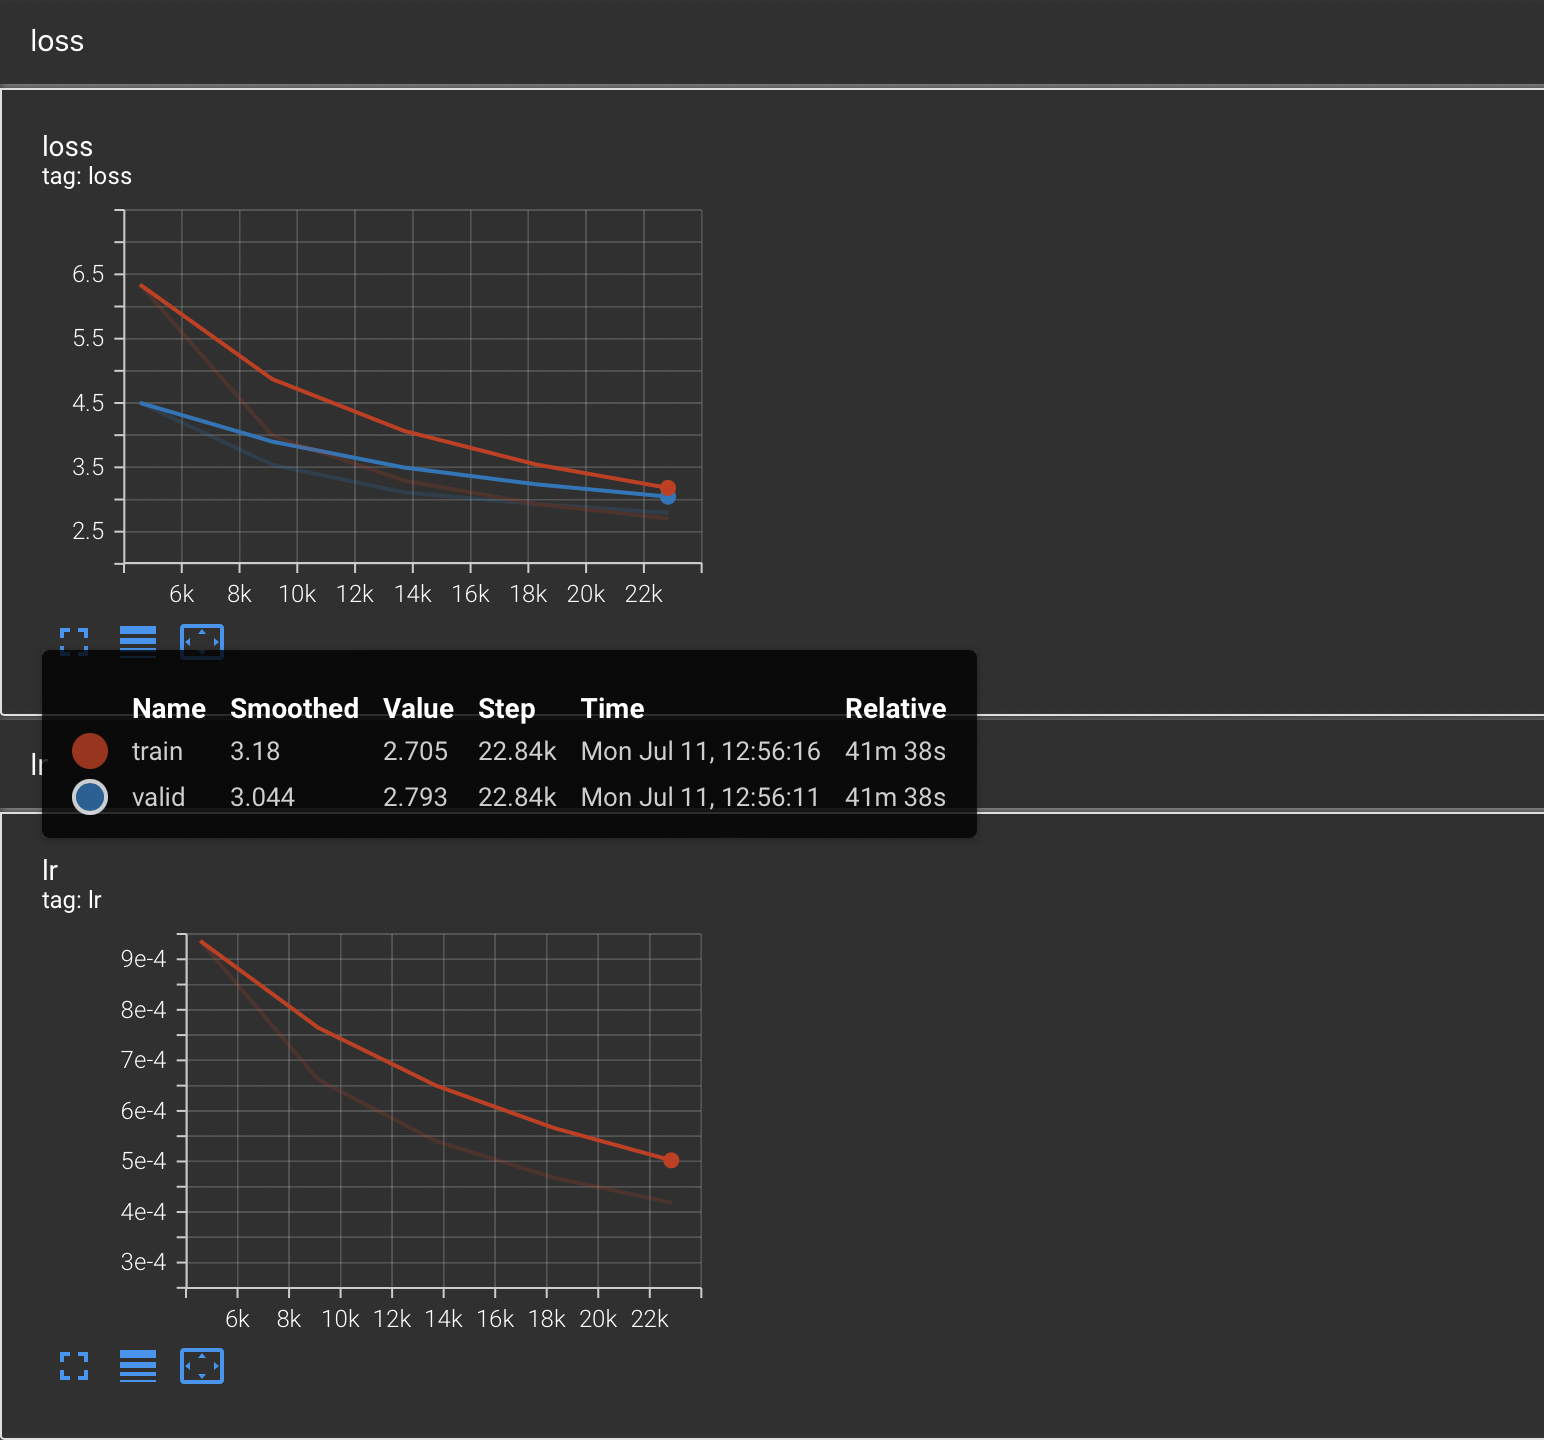

In [5]:
from IPython.display import Image,display_png

display_png(Image('out_96/tensorboard_results.png', width=800))

### 97. ハイパー・パラメータの調整
ニューラルネットワークのモデルや，そのハイパーパラメータを変更しつつ，開発データにおけるBLEUスコアが最大となるモデルとハイパーパラメータを求めよ．

色々試してみた結果：5 epochで最も高い BLEU score が得られるのは 97-3 (criterion, warmup-update, update-freq を変更した場合/ max bleu: 19.08)。 97-4 では weight_decay や adam の beta をより適切に設定すればこれを超えられるかもしれない。

- 1: Try removing `--encoder-normalize-before --decoder-normalize-before`

In [9]:
!CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --dropout 0.2 \
    --criterion cross_entropy \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt \
    --max-epoch 5 \
    --save-dir out_97/97_1/checkpoints \
    > out_97/97_1/log_97_1.log

epoch 001:   0%|                                       | 0/3599 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 3598/3599 [12:48<00:00,  4.69it/s, loss=6.245, ppl=75.86, wps
epoch 001 | valid on 'valid' subset:   0%|               | 0/13 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  15%|█      | 2/13 [00:00<00:00, 12.22it/s]
epoch 001 | valid on 'valid' subset:  31%|██▏    | 4/13 [00:00<00:00, 14.31it/s]
epoch 001 | valid on 'valid' subset:  46%|███▏   | 6/13 [00:00<00:00, 14.55it/s]
epoch 001 | valid on 'valid' subset:  62%|████▎  | 8/13 [00:00<00:00, 14.44it/s]
epoch 001 | valid on 'valid' subset:  77%|████▌ | 10/13 [00:00<00:00, 14.39it/s]
epoch 001 | valid on 'valid' subset:  92%|█████▌| 12/13 [00:00<00:00, 14.07it/s]
epoch 002: 100%|▉| 3598/3599 

In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def bleu_by_beam(path_name, beams):
    for N in beams:
        # 各 beam 幅の場合の翻訳文を生成
        !CUDA_VISIBLE_DEVICES=1 fairseq-interactive data-bin-1 \
        --path {path_name}/checkpoints/checkpoint_best.pt \
        -s ja -t en \
        --beam {N} \
        < kftt-data-1.0/data/tok/kyoto-dev.ja | grep '^H' | cut -f3 > {path_name}/dev_{N}.out

        # 各ビーム幅の場合 BLEU score を求める
        !fairseq-score --sys {path_name}/dev_{N}.out --ref kftt-data-1.0/data/tok/kyoto-dev.en > {path_name}/bleu_{N}.score

def plot_bleu_beam(path_name, beams):
    score_list = []
    for N in beams:
        with open(path_name+"/bleu_"+str(N)+".score", "r") as f:
            texts = f.read()
            score = re.search(r"(?<=BLEU4\s=\s)\d+\.\d+(?=,)", texts)
            score_list.append(float(score.group(0)))

    print(f"max bleu: {max(score_list)}, beam: {beams[score_list.index(max(score_list))]}")
    plt.plot(beams, score_list)
    plt.xlabel("#beam search")
    plt.ylabel("BLEU (4-grams)")
    plt.show()

結果：なぜか BLEU score が非常に低かった... -> unstable?

In [ ]:
beams = [1] + list(range(10, 101, 10)) # 1, 10, 20, 30, ..., 100
bleu_by_beam("out_97/97_1", beams)

max bleu: 0.2, beam: 20


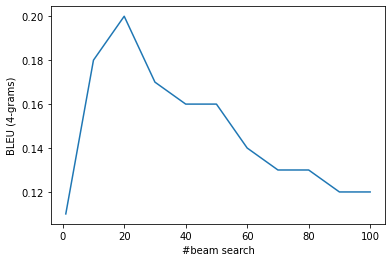

In [30]:
plot_bleu_beam("out_97/97_1", beams)

- 2: learning rate - warmup を追加

In [16]:
!CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion cross_entropy \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-init-lr 1e-6 \
    --max-epoch 5 \
    --save-dir out_97/97_2/checkpoints \
    > out_97/97_2/log_97_2.log

epoch 001:   0%|                                       | 0/3599 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 3598/3599 [12:54<00:00,  4.68it/s, loss=5.321, ppl=39.98, wps
epoch 001 | valid on 'valid' subset:   0%|               | 0/13 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  15%|█      | 2/13 [00:00<00:00, 12.48it/s]
epoch 001 | valid on 'valid' subset:  31%|██▏    | 4/13 [00:00<00:00, 14.39it/s]
epoch 001 | valid on 'valid' subset:  46%|███▏   | 6/13 [00:00<00:00, 14.55it/s]
epoch 001 | valid on 'valid' subset:  62%|████▎  | 8/13 [00:00<00:00, 14.40it/s]
epoch 001 | valid on 'valid' subset:  77%|████▌ | 10/13 [00:00<00:00, 14.34it/s]
epoch 001 | valid on 'valid' subset:  92%|█████▌| 12/13 [00:00<00:00, 13.99it/s]
epoch 002: 100%|▉| 3598/3599 

In [ ]:
beams = [1] + list(range(10, 101, 10)) # 1, 10, 20, 30, ..., 100
bleu_by_beam("out_97/97_2", beams)

max bleu: 18.45, beam: 60


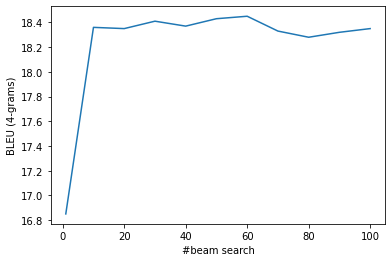

In [31]:
plot_bleu_beam("out_97/97_2", beams)

- 3: criterion label_smoothed_cross_entropy, warmup-update, update-freq を変更

- `--warmup-updates`: このパラメータの回数分のminibatchを処理した段階でlrが最大値になります。1epochのminibatchの数は後述のパラメータで大きく変わるので、変更し忘れないように注意して下さい
- `--update-freq`:  何回かのminibatchの勾配をまとめます。バッチサイズを擬似的に大きくしたいときに使います

from: https://tech.mntsq.co.jp/entry/2020/11/13/160928

In [ ]:
# !CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
#     --task translation \
#     --max-tokens 4096 \
#     --arch transformer \
#     --encoder-normalize-before --decoder-normalize-before \
#     --dropout 0.2 \
#     --criterion cross_entropy \
#     --optimizer adam \
#     --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-init-lr 1e-6 \
#     --warmup-updates 4000 --update-freq 2 \ 
#     --max-epoch 5 \
#     --save-dir out_97/97_2_2/checkpoints \
#     > out_97/97_2_2/log_97_2.log

In [6]:
!CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-init-lr 1e-6 \
    --warmup-updates 4000 --update-freq 2 \
    --max-epoch 5 \
    --save-dir out_97/97_3/checkpoints \
    --tensorboard-logdir out_97/97_3/tb_log \
    > out_97/97_3/log_97_3.log

epoch 001:   0%|                                       | 0/1800 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 1799/1800 [12:29<00:00,  2.42it/s, loss=7.262, nll_loss=5.943
epoch 001 | valid on 'valid' subset:   0%|               | 0/13 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  15%|█      | 2/13 [00:00<00:00, 12.22it/s]
epoch 001 | valid on 'valid' subset:  31%|██▏    | 4/13 [00:00<00:00, 14.10it/s]
epoch 001 | valid on 'valid' subset:  46%|███▏   | 6/13 [00:00<00:00, 14.29it/s]
epoch 001 | valid on 'valid' subset:  62%|████▎  | 8/13 [00:00<00:00, 14.12it/s]
epoch 001 | valid on 'valid' subset:  77%|████▌ | 10/13 [00:00<00:00, 14.06it/s]
epoch 001 | valid on 'valid' subset:  92%|█████▌| 12/13 [00:00<00:00, 13.72it/s]
epoch 002: 100%|▉| 1799/1800 

In [ ]:
beams = [1] + list(range(10, 101, 10)) # 1, 10, 20, 30, ..., 100
bleu_by_beam("out_97/97_3", beams)

max bleu: 19.08, beam: 20


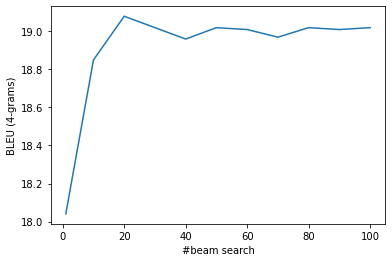

In [32]:
plot_bleu_beam("out_97/97_3", beams)

- 4: + weight-decay / adam-betas

In [24]:
!CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --optimizer adam --adam-betas '(0.9, 0.997)' \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-init-lr 1e-6 \
    --warmup-updates 4000 \
    --weight-decay 0.0001 \
    --max-epoch 5 \
    --save-dir out_97/97_4/checkpoints \
    --tensorboard-logdir out_97/97_4/tb_log \
    > out_97/97_4/log_97_4.log

epoch 001:   0%|                                       | 0/3599 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 3598/3599 [13:20<00:00,  4.54it/s, loss=6.87, nll_loss=5.478,
epoch 001 | valid on 'valid' subset:   0%|               | 0/13 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  15%|█      | 2/13 [00:00<00:00, 12.25it/s]
epoch 001 | valid on 'valid' subset:  31%|██▏    | 4/13 [00:00<00:00, 14.13it/s]
epoch 001 | valid on 'valid' subset:  46%|███▏   | 6/13 [00:00<00:00, 14.28it/s]
epoch 001 | valid on 'valid' subset:  62%|████▎  | 8/13 [00:00<00:00, 14.15it/s]
epoch 001 | valid on 'valid' subset:  77%|████▌ | 10/13 [00:00<00:00, 14.08it/s]
epoch 001 | valid on 'valid' subset:  92%|█████▌| 12/13 [00:00<00:00, 13.75it/s]
epoch 002: 100%|▉| 3598/3599 

In [ ]:
bleu_by_beam("out_97/97_4", beams)

max bleu: 19.02, beam: 10


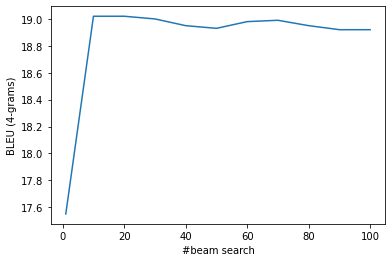

In [34]:
plot_bleu_beam("out_97/97_4", beams)

結論：5 epochで最も高い BLEU score が得られるのは 97-3 (max bleu: 19.08)。 97-4 では weight_decay や adam の beta をより適切に設定すればこれを超えられるかもしれない。

- 5: 91.のを 10 epochs に

In [4]:
!CUDA_VISIBLE_DEVICES=1 fairseq-train data-bin-1 \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion cross_entropy \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt \
    --max-epoch 10 \
    --save-dir out_97/97_5/checkpoints \
    > out_97/97_5/log_97_5.log

epoch 001:   0%|                                       | 0/3599 [00:00<?, ?it/s]/home/anantaprayoon-p/anaconda3/lib/python3.8/site-packages/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(
epoch 001: 100%|▉| 3598/3599 [12:54<00:00,  4.67it/s, loss=5.335, ppl=40.37, wps
epoch 001 | valid on 'valid' subset:   0%|               | 0/13 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  15%|█      | 2/13 [00:00<00:00, 12.28it/s]
epoch 001 | valid on 'valid' subset:  31%|██▏    | 4/13 [00:00<00:00, 14.30it/s]
epoch 001 | valid on 'valid' subset:  46%|███▏   | 6/13 [00:00<00:00, 14.49it/s]
epoch 001 | valid on 'valid' subset:  62%|████▎  | 8/13 [00:00<00:00, 14.40it/s]
epoch 001 | valid on 'valid' subset:  77%|████▌ | 10/13 [00:00<00:00, 14.34it/s]
epoch 001 | valid on 'valid' subset:  92%|█████▌| 12/13 [00:00<00:00, 14.01it/s]
epoch 002: 100%|▉| 3598/3599 

In [ ]:
beams = [1] + list(range(10, 101, 10)) # 1, 10, 20, 30, ..., 100
bleu_by_beam("out_97/97_5", beams)

max bleu: 18.9, beam: 10


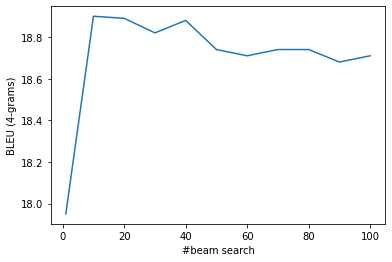

In [4]:
beams = [1] + list(range(10, 101, 10)) # 1, 10, 20, 30, ..., 100
plot_bleu_beam("out_97/97_5", beams)

### 98. ドメイン適応
[Japanese-English Subtitle Corpus (JESC)](https://nlp.stanford.edu/projects/jesc/index_ja.html)や[JParaCrawl](http://www.kecl.ntt.co.jp/icl/lirg/jparacrawl/)などの翻訳データを活用し，KFTTのテストデータの性能向上を試みよ．

自分の手法:
- JParaCrawl を用いる (KFTT と同じくらいのデータ数). 
- サブワード化: JParaCrawl と KFTT データを合わせてサブワードを学習
- データの前処理 (fairseq-preprocess): JParaCrawl と KFTT データを合わせて dict を作成する
- 学習: JParaCrawl と KFTT データを合わせて学習させる 

疑問:
- サブワード化 - JParaCrawl と KFTT を合わせてサブワードを学習 vs いずれかを使って学習する?、orig vs tok データから学習する?
- データの前処理 (fairseq-preprocess) - JParaCrawl と KFTT を合わせて dict 作る vs いずれかを使って dict 作る?
- 学習は一緒で？別々で？
- Fine-tuning のようにやれば多分一緒にサブワード化したり学習したりすることが正解? → けど語彙のドメインが異なるためサブワード/dict作るときに工夫が必要となるかもしれない

to-try (できれば):
- do separately, with larger JParaCrawl data size
- 学習したモデルから fine-tune したいときに: `finetune_from_model`
- shuffle
- 先にトークン化、そして sentenpiece?

In [7]:
# !tar -xf en-ja.tar
!wc -l en-ja/en-ja.bicleaner05.txt
!head -n 3 en-ja/en-ja.bicleaner05.txt

25740835 en-ja/en-ja.bicleaner05.txt
0001vip.cocolog-nifty.com	0001vip.cocolog-nifty.com	0.535	And everyone will not care that it is not you.	鼻・口のところはあらかじめ少し切っておくといいですね。
0001vip.cocolog-nifty.com	0001vip.cocolog-nifty.com	0.557	And everyone will not care that it is not you.	アドレス置いとくので、消されないうちにメールくれたら嬉しいです。
000-lhr.web.wox.cc	000-lhr.web.wox.cc	0.743	Sponsored link This advertisement is displayed when there is no update for a certain period of time.	スポンサードリンク この広告は一定期間更新がない場合に表示されます。


In [10]:
# Preprocessing (前処理)
# train, dev, test に分割
# en, jp に分割
train_size = 400000
dev_size = 2000
test_size = 2000
!head -n {train_size} en-ja/en-ja.bicleaner05.txt | cut -f 4 > jpara-data/orig/jpara-train.en
!head -n {train_size} en-ja/en-ja.bicleaner05.txt | cut -f 5 > jpara-data/orig/jpara-train.ja
!head -n {train_size+dev_size} en-ja/en-ja.bicleaner05.txt | tail -n {dev_size} | cut -f 4 > jpara-data/orig/jpara-dev.en
!head -n {train_size+dev_size} en-ja/en-ja.bicleaner05.txt | tail -n {dev_size} | cut -f 5 > jpara-data/orig/jpara-dev.ja
!head -n {train_size+dev_size+test_size} en-ja/en-ja.bicleaner05.txt | tail -n {test_size} | cut -f 4 > jpara-data/orig/jpara-test.en
!head -n {train_size+dev_size+test_size} en-ja/en-ja.bicleaner05.txt | tail -n {test_size} | cut -f 5 > jpara-data/orig/jpara-test.ja

In [11]:
!head -n 5 jpara-data/orig/jpara-train.en
!head -n 5 jpara-data/orig/jpara-train.ja

And everyone will not care that it is not you.
And everyone will not care that it is not you.
Sponsored link This advertisement is displayed when there is no update for a certain period of time.
Also, it will always be hidden when becoming a premium user .
It will return to non-display when content update is done.
鼻・口のところはあらかじめ少し切っておくといいですね。
アドレス置いとくので、消されないうちにメールくれたら嬉しいです。
スポンサードリンク この広告は一定期間更新がない場合に表示されます。
また、 プレミアムユーザー になると常に非表示になります。
コンテンツの更新が行われると非表示に戻ります。


In [1]:
# トークン化/サブワード化
# jparacrawl と kftt データを結合
!cat jpara-data/orig/jpara-train.en kftt-data-1.0/data/orig/kyoto-train.en > jpara-kftt-data/orig/jk-train.en
!cat jpara-data/orig/jpara-train.ja kftt-data-1.0/data/orig/kyoto-train.ja > jpara-kftt-data/orig/jk-train.ja
# サブワードの学習
!subword-nmt learn-bpe -s 16000 < jpara-kftt-data/orig/jk-train.en > out_98/codes_98.en
!subword-nmt learn-bpe -s 16000 < jpara-kftt-data/orig/jk-train.ja > out_98/codes_98.ja

100%|#####################################| 16000/16000 [08:27<00:00, 31.54it/s]


In [4]:
!cat jpara-data/orig/jpara-train.en kftt-data-1.0/data/orig/kyoto-dev.en > jpara-kftt-data/orig/jk-dev.en
!cat jpara-data/orig/jpara-train.en kftt-data-1.0/data/orig/kyoto-test.en > jpara-kftt-data/orig/jk-test.en
!cat jpara-data/orig/jpara-train.ja kftt-data-1.0/data/orig/kyoto-dev.ja > jpara-kftt-data/orig/jk-dev.ja
!cat jpara-data/orig/jpara-train.ja kftt-data-1.0/data/orig/kyoto-test.ja > jpara-kftt-data/orig/jk-test.ja

In [5]:
# 学習したサブワードによって train/dev/test データ（文章）のサブワード化されたファイルを作成
# jpara-kftt
!subword-nmt apply-bpe -c out_98/codes_98.en < jpara-kftt-data/orig/jk-train.en > jpara-kftt-data/subw/jk-train.en
!subword-nmt apply-bpe -c out_98/codes_98.en < jpara-kftt-data/orig/jk-dev.en > jpara-kftt-data/subw/jk-dev.en
!subword-nmt apply-bpe -c out_98/codes_98.en < jpara-kftt-data/orig/jk-test.en > jpara-kftt-data/subw/jk-test.en

!subword-nmt apply-bpe -c out_98/codes_98.ja < jpara-kftt-data/orig/jk-train.ja > jpara-kftt-data/subw/jk-train.ja
!subword-nmt apply-bpe -c out_98/codes_98.ja < jpara-kftt-data/orig/jk-dev.ja > jpara-kftt-data/subw/jk-dev.ja
!subword-nmt apply-bpe -c out_98/codes_98.ja < jpara-kftt-data/orig/jk-test.ja > jpara-kftt-data/subw/jk-test.ja

# kftt's test data
!subword-nmt apply-bpe -c out_98/codes_98.en < kftt-data-1.0/data/orig/kyoto-test.en > jpara-kftt-data/subw/kyoto-test.en
!subword-nmt apply-bpe -c out_98/codes_98.ja < kftt-data-1.0/data/orig/kyoto-test.ja > jpara-kftt-data/subw/kyoto-test.ja

In [6]:
!fairseq-preprocess \
    -s ja -t en \
    --trainpref jpara-kftt-data/subw/jk-train \
    --validpref jpara-kftt-data/subw/jk-dev \
    --testpref jpara-kftt-data/subw/jk-test \
    --destdir out_98/data-bin \
    --thresholdtgt 5 \
    --thresholdsrc 5 \
    --workers 16 \
    --task translation

2022-07-19 13:14:31 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='out_98/data-bin', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='ja', srcdict=Non

In [ ]:
# Training (学習)
# jparacrawl データで学習を行う
!CUDA_VISIBLE_DEVICES=1 fairseq-train out_98/data-bin \
    --task translation \
    --max-tokens 4096 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --dropout 0.2 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --optimizer adam \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-init-lr 1e-6 \
    --warmup-updates 4000 --update-freq 2 \
    --max-epoch 5 \
    --save-dir out_98/checkpoints \
    --tensorboard-logdir out_98/tb_log \
    > out_98/log_98.log

In [9]:
src_text = '天気がいいから、散歩しましょう。'
!echo {src_text} | mecab -Owakati | CUDA_VISIBLE_DEVICES=1 fairseq-interactive out_98/data-bin \
    --path out_98/checkpoints/checkpoint_best.pt \
    -s ja -t en \
    --beam 5 \
    | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g'

2022-07-19 15:10:36 | INFO | fairseq_cli.interactive | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_na

In [ ]:
# beam search
beams = [1] + list(range(10, 101, 10)) # 1, 10, 20, 30, ..., 100
for N in beams:
    # 各 beam 幅の場合の翻訳文を生成
    !CUDA_VISIBLE_DEVICES=1 fairseq-interactive out_98/data-bin \
    --path out_98/checkpoints/checkpoint_best.pt \
    -s ja -t en \
    --beam {N} \
    < jpara-kftt-data/subw/kyoto-test.ja | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g' > out_98/beam/test_{N}.out

    # 各ビーム幅の場合 BLEU score を求める
    !fairseq-score --sys out_98/beam/test_{N}.out --ref kftt-data-1.0/data/tok/kyoto-test.en > out_98/beam/bleu_{N}.score

In [ ]:
!CUDA_VISIBLE_DEVICES=1 fairseq-interactive out_98/data-bin \
    --path out_98/checkpoints/checkpoint_best.pt \
    -s ja -t en \
    --beam 5 \
    < jpara-kftt-data/subw/kyoto-test.ja | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g' > out_98/beam/test_5.out

!fairseq-score --sys out_98/beam/test_5.out --ref kftt-data-1.0/data/tok/kyoto-test.en > out_98/beam/bleu_5.score

In [14]:
!cat out_98/beam/bleu_5.score

Namespace(ignore_case=False, order=4, ref='kftt-data-1.0/data/tok/kyoto-test.en', sacrebleu=False, sentence_bleu=False, sys='out_98/beam/test_5.out')
BLEU4 = 9.75, 42.0/17.7/8.2/4.0 (BP=0.780, ratio=0.801, syslen=21422, reflen=26734)


In [17]:
import re
import matplotlib.pyplot as plt

max bleu: 9.87, beam: 10


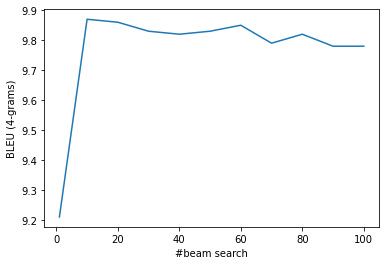

In [18]:
# plot
score_list = []
for N in beams:
    with open("out_98/beam/bleu_"+str(N)+".score", "r") as f:
        texts = f.read()
        score = re.search(r"(?<=BLEU4\s=\s)\d+\.\d+(?=,)", texts)
        score_list.append(float(score.group(0)))

print(f"max bleu: {max(score_list)}, beam: {beams[score_list.index(max(score_list))]}")
plt.plot(beams, score_list)
plt.xlabel("#beam search")
plt.ylabel("BLEU (4-grams)")
plt.show()

### 99. 翻訳サーバの構築
ユーザが翻訳したい文を入力すると，その翻訳結果がウェブブラウザ上で表示されるデモシステムを構築せよ．

- `99/app.py` を参照

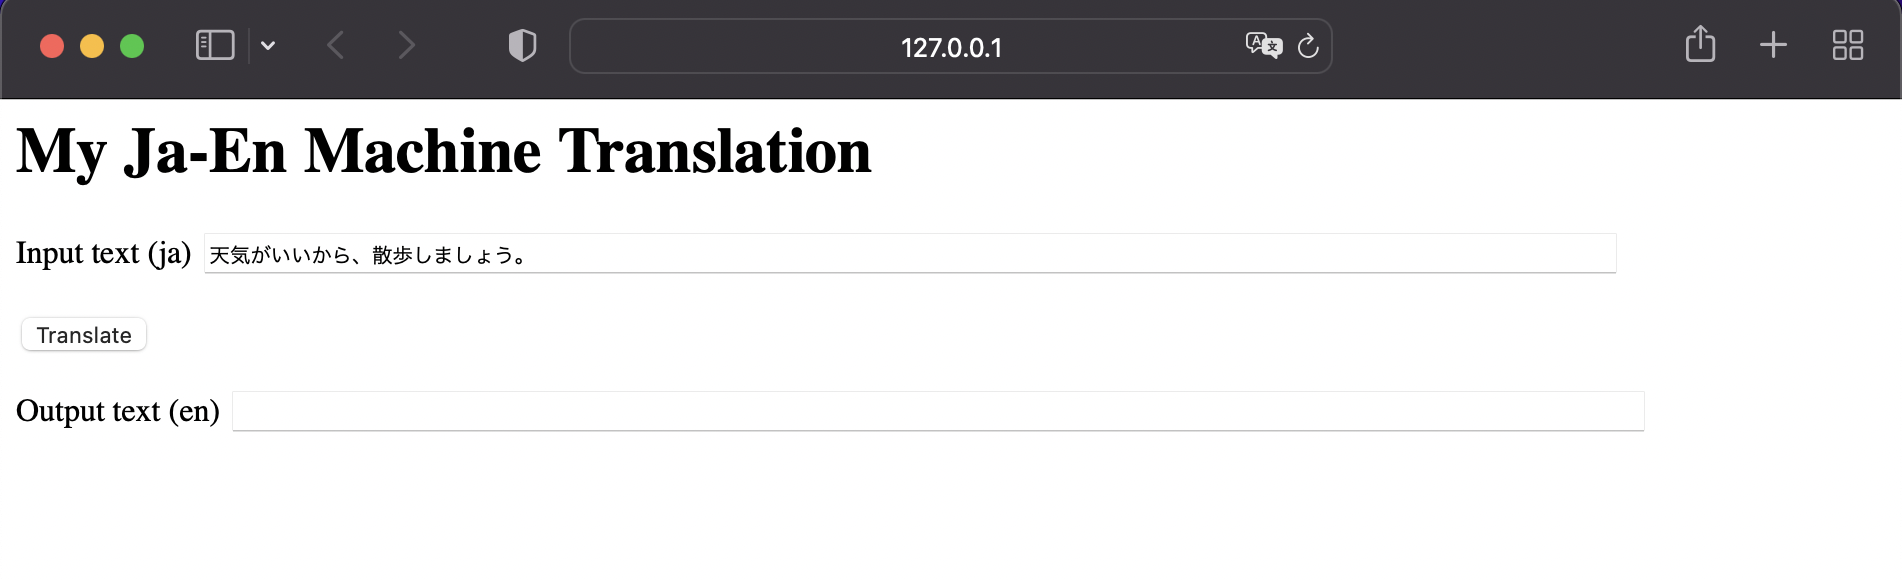

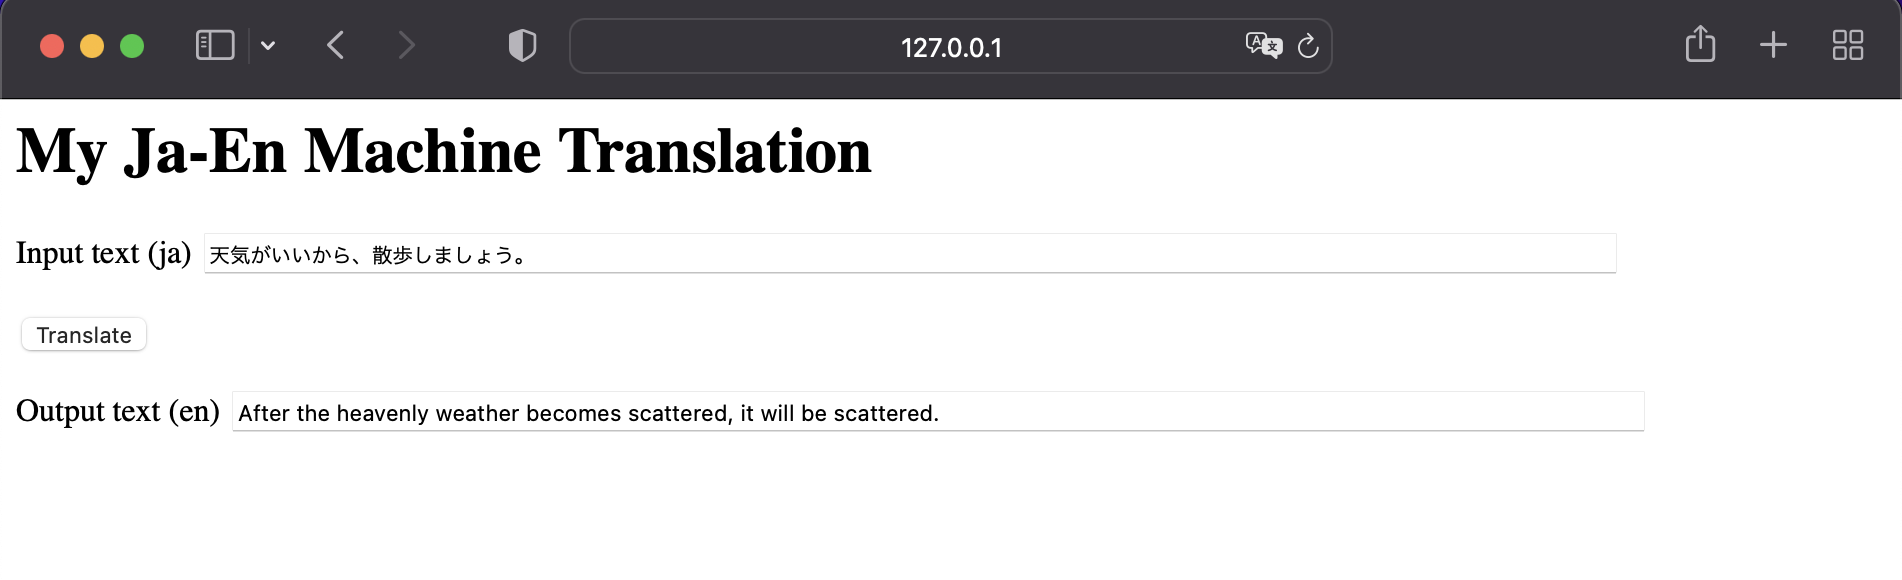

In [2]:
from IPython.display import Image,display_png

display_png(Image('99/99_in.png', width=800))
display_png(Image('99/99_out.png', width=800))